# Setting Up

I first set up topic models locally to determine parameters (e.g. learning rate bounds) and then performed model tuning with GPU support by submitting python scripts as jobs on the UCSF Wynton computing cluster: https://wynton.ucsf.edu/hpc/index.html

**On Wynton dev node, load conda via:**    
module load CBI miniconda3-py39 

**Load Cuda for GPU support:**  
module load Sali cuda 

**Load conda environment before launching/running this notebook:**  
conda activate mira-env
  
**Easiest way to set up this environment is using conda_MIRAenv_spec_file.txt**
  
**Otherwise, to manually set up conda environment:**  
  
**First add channels and set priority to strict**  
conda config --add channels conda-forge  
conda config --add channels pytorch  
conda config --add channels bioconda  
conda config --add channels liulab-dfci 
conda config --set channel_priority strict  
  
**Check channel info:**  
conda config --get  
    
**Create mira-env:**  
conda create --name mira-env -c conda-forge -c pytorch -c bioconda -c liulab-dfci mira-multiome scanpy jupyter leidenalg -y  
conda activate mira-env

**Check packages:**  
conda list

**For use with GPU, add pytorch with cuda toolkit:**  
conda config --set channel-priority flexible  
conda install pytorch=1.12.1 cudatoolkit=11.5 -c pytorch -y  
  
**If necessary, install pillow version 9.2.0 into mira-env (had issues with 9.4.0):**  
conda install pillow=9.2.0  
  
**Add jupyter notebook kernel:**  
python -m ipykernel install --user --name mira-env

# Topic Modeling

NOTE: The topic model tuning and training is run completely independently for RNA and ATAC data. So the most efficient way to do this in the future will be to use the Jupyter notebook to run through the learning rate determination steps for each modality to determine the parameters for trimming the learning rate bounds. Then, tuning and training can be set up as two different job submissions on Wynton GPU nodes and run concurrently

**Import Packages and Load Data**

In [1]:
import mira
import anndata
import scanpy as sc
import optuna
import scipy.sparse as sp
import numpy as np
import pandas as pd
mira.utils.pretty_sderr()

! cd /wynton/home/bruneau/jmuncie/MIRA_analysis/Mef2c
data_RNA = anndata.read_h5ad("Mef2c_RNA_AnnData.h5ad")
data_Peaks = anndata.read_h5ad("Mef2c_Peaks_AnnData.h5ad")

#Convert sparse matrix in data_Peaks object to compressed sparsed row (CSR) format
data_Peaks.X = data_Peaks.X.tocsr()

**Check if GPUs are available**

In [1]:
import torch

#Check if GPUs are available and which is currently being used
if torch.cuda.is_available():
    print("Current CUDA device index:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available")
    
#Note: There are two GPUs connected to Wynton gpudev1, designated by indexes(i) 0 and 1
#To check the memory usage of each, run $nvidia-smi -i 0 and $nvidia-smi -i 1
#To set which is to be used, run $export CUDA_VISIBLE_DEVICES=i in conda environment before launching jupyter notebook

Current CUDA device index: Tesla K80


**Expression Model Preprocessing**

In [2]:
#Filter rare genes
sc.pp.filter_genes(data_RNA, min_cells=50)

#Freeze the raw counts data
rawdata = data_RNA.X.copy()

In [3]:
#Normalize read depth and logarithmize the data
sc.pp.normalize_total(data_RNA, target_sum=1e4)
sc.pp.log1p(data_RNA)

In [4]:
#Calculate"exogenous" gene set for model training 
#These genes show some variable expression but perhaps not enough to be informative to the encoder network
sc.pp.highly_variable_genes(data_RNA, min_disp = 0.1)

#Check how many genes in highly_variable with min_disp = 0.1
n_low_disp = data_RNA.var.highly_variable.sum()
display("Number hv with disp=0.1:", n_low_disp)

#Check how many genes in highly_variable with min_disp = 0.2
data_RNA.var['hv_higher_disp'] = data_RNA.var.highly_variable & (data_RNA.var.dispersions_norm > 0.2)
n_high_disp = data_RNA.var.hv_higher_disp.sum()
display("Number hv with disp=0.2:", n_high_disp)

'Number hv with disp=0.1:'

4088

'Number hv with disp=0.2:'

3568

In [5]:
#Set exogenous gene set 
#NOTE: comment out line you do not want to use

#For set with min_disp cutoff = 0.1:
data_RNA.var['exog'] = data_RNA.var.highly_variable.copy()

#For set with min_disp cutoff = 0.2:
#data_RNA.var['exog'] = data_RNA.var.hv_higher_disp.copy()

In [6]:
#Calculate the “endogenous” gene set by intersecting the exogenous set with genes with a higher dispersion threshold
#These should be the most highly variable, targeting approx. top 2000 genes
data_RNA.var['endog'] = data_RNA.var.exog & (data_RNA.var.dispersions_norm > 0.7)

#Check how many genes in "endog", adjust if needed 
n_endog = data_RNA.var.endog.sum()
display("Number of endogenous features:", n_endog)

'Number of endogenous features:'

1959

In [7]:
#Restore the raw counts data to the "counts" layer as integers
data_RNA.layers['counts'] = rawdata

/wynton/home/bruneau/jmuncie/.conda/envs/mira-env/lib/python3.7/site-packages/anndata/_core/raw.py:146: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  uns=self._adata.uns.copy(),


**Expression Topic Model Setup**

In [8]:
#Instantiate an expression topic model
exp_model = mira.topics.ExpressionTopicModel(
    endogenous_key='endog',
    exogenous_key='exog',
    counts_layer='counts',
    seed = 0,
    hidden=128, 
)

In [9]:
#MIRA uses a training scheme where we must define the upper and lower bounds of the model learning rate
#get_learning_rate_bounds runs an array of learning rates to find the values for which the model is most responsive
exp_model.get_learning_rate_bounds(data_RNA, eval_every=5, upper_bound_lr=5)

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: exog
INFO:mira.adata_interface.topic_model:Using highly-variable genes from col: endog


Learning rate range test:   0%|          | 0/134 [00:00<?, ?it/s]

ERROR:mira.topic_model.base:
Gradient overflow from too high learning rate, stopping test early.
INFO:mira.topic_model.base:Set learning rates to: (5.025474989776966e-06, 0.2829554841943139)


(5.025474989776966e-06, 0.2829554841943139)

<AxesSubplot:xlabel='Learning Rate', ylabel='Loss'>

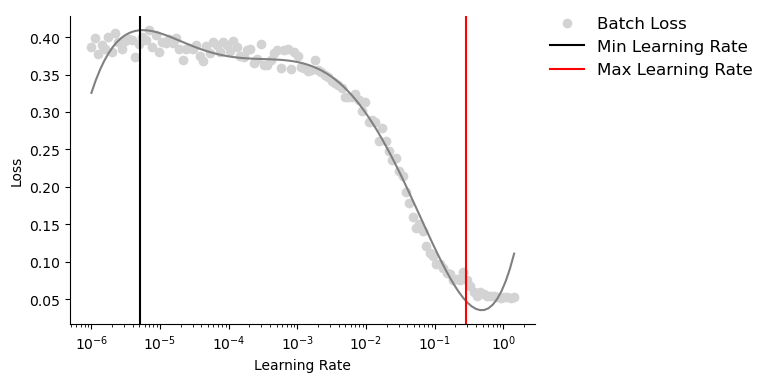

In [10]:
#Plot the learning rate vs. loss curve 
exp_model.plot_learning_rate_bounds(figsize=(6, 4), ax=None)

INFO:mira.topic_model.base:Set learning rates to: (0.009086271934304904, 0.1716211764976848)


<AxesSubplot:xlabel='Learning Rate', ylabel='Loss'>

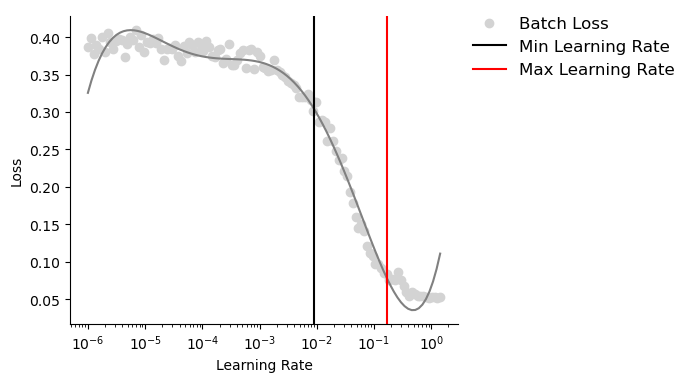

In [17]:
#Trim bounds to encompass the portion of the plot with the steepest slop
#Note: first variable describes log increase in min bound, second is log decrease in max bound
exp_model.trim_learning_rate_bounds(7.5,1) 
exp_model.plot_learning_rate_bounds(figsize=(5, 4), ax=None)

**Expression Model Tuning and Training**

In [ ]:
#Instantiate a model tuner
#Tuning event files are stored in the execution directory under runs/<save_name>
exp_tuner = mira.topics.TopicModelTuner(
    exp_model,
    seed = 0,
    iters=64, 
    max_topics = 55, 
    save_name = 'tuning-mef2c-RNA',
    tensorboard_logdir='mira_tuning_runs', 
    storage='sqlite:///mira_mef2c_RNA_tuning.db'
)

In [ ]:
#Have the tuner split the data into training and test sets
exp_tuner.train_test_split(data_RNA)

#Save AnnData object now that train/test data is labeled
#This way, if training is interrupted, you should be able to resume training or reload and run select_best_model 
data_RNA.write_h5ad(filename="Mef2c_RNA_AnnData.h5ad")

In [ ]:
#User Tensorboard to view the results of tuning 
$ conda create --name tensorboard -y -c conda-forge tensorboard
$ conda activate tensorboard
$ tensorboard serve --logdir /path/to/workingdir/runs/<save_name>

In [ ]:
#Start tuning!
exp_tuner.tune(data_RNA, n_workers=16)

#Took about 20 hours for dataset with ~11,000 cells with 16 workers
#So each trial took ~5h (20/4 because with 16 parallel workers, each worker must complete 4 trials in 20 h)
#Each worker using ~350MiB memory, had errors when attempting to use >16 workers on Wynton gpudev1

In [ ]:
#Reload and print results dashboard from an interrupted study
study_RNA = mira.topics.TopicModelTuner.load_study(
    study_name="tuning-mef2c-RNA", 
    storage = 'sqlite:///mira_mef2c_RNA_tuning.db'
)
mira.topics.print_study(study_RNA)

In [ ]:
#Select best model
exp_tuner.select_best_model(data_RNA, record_umaps=True)

In [ ]:
#Model has been tuned and trained! Save it
! mkdir -p models
exp_model.save("Mef2c_RNA_ExpressionTopicModel.pth") #Note, we are calling the variable name we set when we first set up the model, before tuning and training

**Export top 200 genes from each gene expression topic**

In [ ]:
#Note: A good rule of thumb for setting top_n genes is to take the top 5% of genes 
#modeled by the expression topic model. 
#In my case, I modeled ~4000 genes, so I look at the top 200 genes per topic

mef2c_exp_model = mira.topics.ExpressionTopicModel.load('Mef2c_RNA_ExpressionTopicModel.pth')

titles = [f"Topic_{i}" for i in range(33)]

for i in range(33):
    top = mef2c_exp_model.get_top_genes(i, top_n=200)
    df = pd.DataFrame(top)
    # Save the DataFrame to a CSV file
    df.to_csv("Top200_Genes_"+titles[i]+".csv", index=False, header=False)

**Accessibility Topic Model Setup**

In [18]:
#Instantiate an accessibility topic model, using all default parameters
#Note: I am not setting dataset_loader_workers because training will be parallelized on GPU
atac_model = mira.topics.AccessibilityTopicModel(
    seed = 0
)

In [19]:
#MIRA uses a training scheme where we must define the upper and lower bounds of the model learning rate
#get_learning_rate_bounds runs an array of learning rates to find the values for which the model is most responsive
#Running with default parameters
atac_model.get_learning_rate_bounds(data_Peaks, eval_every=5)

Learning rate range test:   0%|          | 0/134 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Set learning rates to: (6.4049904240556506e-06, 0.10026530538588793)


(6.4049904240556506e-06, 0.10026530538588793)

<AxesSubplot:xlabel='Learning Rate', ylabel='Loss'>

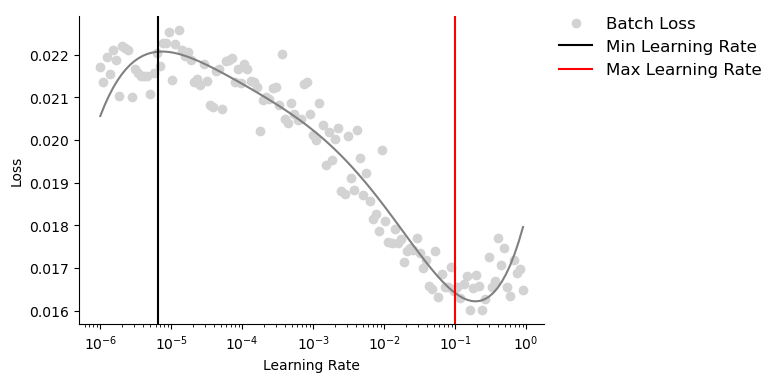

In [20]:
#Plot the learning rate vs. loss curve 
atac_model.plot_learning_rate_bounds(figsize=(6, 4), ax=None)

INFO:mira.topic_model.base:Set learning rates to: (0.0009505848628558509, 0.06081398182199126)


<AxesSubplot:xlabel='Learning Rate', ylabel='Loss'>

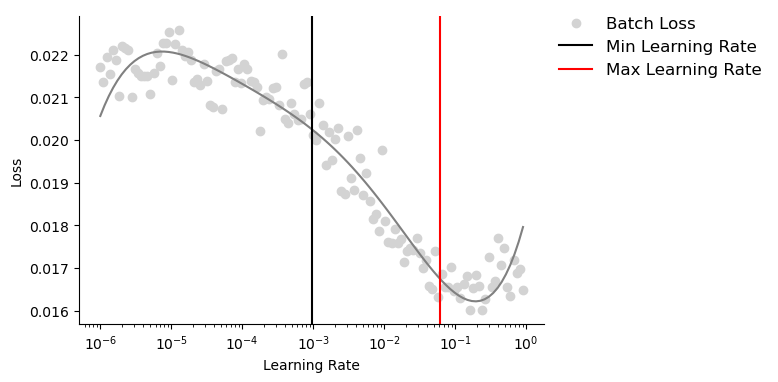

In [22]:
#Trim bounds to encompass the portion of the plot with the steepest slop
#Note: first variable describes log increase in min bound, second is log decrease in max bound
atac_model.trim_learning_rate_bounds(5,1) 
atac_model.plot_learning_rate_bounds(figsize=(6, 4), ax=None)

**Accessibility Topic Model Tuning and Training**

In [ ]:
#Instantiate a model tuner
#Tuning event files are stored in the execution directory under runs/<save_name>
atac_tuner = mira.topics.TopicModelTuner(
    atac_model,
    seed = 0,
    iters=64, 
    max_topics = 55, 
    save_name = 'tuning-mef2c-ATAC',
    tensorboard_logdir='mira_tuning_runs', 
    storage='sqlite:///mira_mef2c_ATAC_tuning.db'
)

In [ ]:
#Have the tuner split the data into training and test sets
atac_tuner.train_test_split(data_Peaks)

#Save anndata object now that train/test data is labeled
#This way, if training is interrupted, you should be able to resume training or reload and run select_best_model 
data_Peaks.write_h5ad(filename="Mef2c_Peaks_AnnData.h5ad")

In [ ]:
#User Tensorboard to view the results of tuning 
$ conda create --name tensorboard -y -c conda-forge tensorboard
$ conda activate tensorboard
$ tensorboard serve --logdir /path/to/workingdir/runs/<save_name>

In [ ]:
#Start tuning!
atac_tuner.tune(data_Peaks, n_workers=1)
#Began tuning with 4 workers and each worker using ~2000-2500 MiB
#Eventually seemed to go to a single worker using 4500 MiB, so I tried starting another tune
#But didn't seem to launch a new process and the one that was running jumped up to 7000 MiB
#I think only enough memory on this gpu for one worker to be running at a time

#Eventually failed - seem to run out of memory on GPU. Was able to restart with single worker. 

#Probably best to submit as job on GPU nodes 
#Did write a shell and python script in order to do that

In [ ]:
#Reload and print results dashboard from an interrupted study
study_atac = mira.topics.TopicModelTuner.load_study(
    study_name="tuning-mef2c-ATAC", 
    storage = 'sqlite:///mira_mef2c_ATAC_tuning.db'
)
mira.topics.print_study(study_atac)

In [ ]:
#Select best model
atac_tuner.select_best_model(data_Peaks, record_umaps=True)

In [ ]:
#Model has been tuned and trained! Save it
#Already made models directory when we saved the expression topic model 
#! mkdir -p models
atac_model.save("models/Mef2c_ATAC_TopicModel.pth") #Note, we are calling the variable name we set when we first set up the model, before tuning and training

**Export Motif Enrichment results for each accessibility topic**

In [ ]:
#Add motif annotations 

#Copy the entire AnnData object to avoid messing up
peaks_cp = data_Peaks.copy()

#If needed, convert format of peaks data -> need three separate columns for 'chr', 'start', and 'end'
#Copy the .var feature (peak) data as a dataframe
var_df = peaks_cp.var.copy()
#Remove '-' from chrF6-eGFP to make string splitting work
var_df.idx[194046] = 'chrF6eGFP:18-518'

#Create new data frame with original data split into three columns for chr, start, and end
new_data = {
    'chr': var_df['idx'].str.split(':').str[0],
    'start': pd.to_numeric(var_df['idx'].str.split(':').str[1].str.split('-').str[0], errors='coerce'),
    'end': pd.to_numeric(var_df['idx'].str.split('-').str[1], errors='coerce'),
}
new_df = pd.DataFrame(new_data)
#Add '-' back into chrF6-eGFP so that it matches genome fasta
new_df.chr[194046] = 'chrF6-eGFP'

#Add new data frame to AnnData as .var
peaks_cp.var = new_df

# Rename the index to label it as 'peak_ids'
peaks_cp.var.index.name = 'peak_id'

#Now annotate motifs
mira.tools.motif_scan.logger.setLevel(logging.INFO) # make sure progress messages are displayed

#Need to make sure location of moods-dna.py is in path
#Found using 'which moods-dna.py' in command line
#sys.path.append('/Users/jmuncie/miniconda3/envs/mira-env/bin')

#Prior to running, need to add FASTA for reference genome to location called by function
mira.tl.get_motif_hits_in_peaks(peaks_cp,
                    genome_fasta='genome_mm10/genome_v13.fa',
                    chrom = 'chr', start = 'start', end = 'end',
                    pvalue_threshold=0.0001) # indicate chrom, start, end of peaks

In [ ]:
#Get and export motif enrichment results

mef2c_atac_model = mira.topics.AccessibilityTopicModel.load('models/Mef2c_ATAC_TopicModel.pth')

titles = [f"ATAC_Topic_{i}" for i in range(17)]

for i in range(17):
    #Get enriched TF motifs for topics of interest
    #  Note: top_quantile controls what quantile of peaks are taken to represent the topic. 
    #        Values between 0.1 and 0.2, so the top 10% to 20% peaks, work best.
    mef2c_atac_model.get_enriched_TFs(peaks_cp, topic_num=i, top_quantile=0.2)
    #You can retrieve enrichment results using get_enrichments. Note, this list is not sorted:
    motifs = pd.DataFrame(mef2c_atac_model.get_enrichments(i))
    #Sort the list before you write it out
    motifs_sorted = motifs.sort_values(by='pval', ascending=True)
    #Save the DataFrame to a CSV file
    motifs_sorted.to_csv("Top_Motifs_Sorted_"+titles[i]+".csv", index=False, header=True)